# Competitors

31 October, 2024

@roman

Code to find neighbors of a given competitor for each property

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from scipy.spatial import KDTree
import scipy.sparse as sp
from scipy import io

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# cluster for trails
CLUSTERS_TRIALS = [13, 14] # toluca, acapulco

# subset
gdf_properties = gdf_properties[gdf_properties['city_cluster'].isin(CLUSTERS_TRIALS)]

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

# look
print(gdf_properties.shape)
gdf_properties.head()

(42928, 54)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,geometry
64,1,1,4,SAN LUIS MEXTEPEC,NO APLICA,51355,12,2,2022-11-25,NaN,NaN,NaN,NaN,4,4,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,NaN,3,2,118,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,3,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,c9495ec0-260a-424b-aeb8-3fd289c71664,19.319536,-99.721844,3,2,S/D,2,85.919998,85.919998,82.080002,60.0,NaN,<NA>,1664270.0,1664000.0,964831.87,282355.2,<NA>,69,392740ed-74bc-40e8-9b67-ddfefa28f2aa,0e622238-40a8-533c-912c-d6c827e80e3b,13,POINT (2738734.452 815473.472)
68,1,2,4,FRACCIONAMIENTO GRANJAS DEL MARQUES,NO APLICA,39890,14,1,2022-06-08,NaN,NaN,NaN,NaN,4,4,b84f262d-ea88-49d2-a9ec-ed62260c1c1f,0.0,12,1,NaN,3,2,001,cc205b62-3269-474a-ae20-3a170c376c5b,3,NaN,NaN,NaN,3,NaN,50cadc09-e0cd-44a7-a5ab-3a113070f005,301c5a20-a0e2-4952-beb1-1cc908c8e046,16.803610,-99.823561,3,2,S/D,3,105.769997,124.830002,70.699997,1.0,NaN,<NA>,2185773.0,2186000.0,1209176.09,254520.0,<NA>,69,8c86de18-c3d9-4fe6-88d8-78c050469e3c,9e2d91cd-d41b-583c-933f-887a0b828ef5,14,POINT (2732297.985 537120.475)
244,1,2,4,CONJUNTO URBANO LOMAS VIRREYES II,NO APLICA,52227,0,0,2022-11-24,NaN,NaN,NaN,NaN,4,6,f7f5d6ff-497b-441e-9643-3a532bcb8325,0.0,15,1,NaN,3,2,018,cc205b62-3269-474a-ae20-3a170c376c5b,4,NaN,NaN,NaN,3,NaN,a4ce3b13-cf69-4cbf-a354-05d08579f450,ac4637b6-bbae-4fda-b309-a69a5d07534e,19.192506,-99.608994,3,2,S/D,3,135.240005,135.240005,181.250000,2.0,NaN,<NA>,2888626.0,2889000.0,1684375.00,906250.0,<NA>,70,314f6e31-62a8-4a1c-b7d8-60886bb359e2,44158c28-18e9-58a9-a0de-78c8e02b4421,13,POINT (2750793.038 801644.272)
676,2,3,5,AGRICOLA LAZARO CARDENAS,NO APLICA,52148,0,2,2022-03-31,1.0,3.0,1.0,1.0,5,6,405d98a8-f241-4b41-b962-5926c394907f,0.0,15,3,1.0,3,3,054,7bc546d9-fc16-4791-b0e0-e378fc472b6d,2,1.0,2.0,2.0,2,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,5f98933e-7581-42c9-8566-df62f4162a4d,19.260856,-99.556703,3,3,S/D,4,315.000000,357.950012,202.250000,1.0,1.0,TERRENO PLANO DE CONFIGURACION REGULAR CON UN ...,6645341.0,6645000.0,4746013.57,991025.0,COMO VIA DE ACCESO DE TIPO PRINCIPAL SE TIENE ...,80,7ade3940-905e-4b44-832e-fae353801287,27a8d9b3-a267-52bd-9eab-b26eb68a3e3a,13,POINT (2756148.824 809281.402)
771,0,2,5,BARRA DIAMANTE,NO APLICA,39897,17,0,2022-05-02,NaN,NaN,NaN,NaN,5,4,34e46c5f-11c3-4c22-afc4-ead80d8e108b,0.0,12,3,NaN,3,2,001,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,bfe2dd96-5fa8-43e8-b679-533e42090d64,8e02d214-ce83-4247-b473-7ca7671a3d37,16.757205,-99.767913,3,2,S/D,3,111.809998,111.809998,96.000000,10.0,NaN,<NA>,2738226.0,2738000.0,1133355.93,524160.0,<NA>,79,36328900-5739-4b56-a4b0-24095d0e1ab6,13737ce8-ce76-588e-ac49-d1da995c96da,14,POINT (2738317.014 532069.874)


## Cities

In [4]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/cities.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

# look
print(gdf_cities.shape)
gdf_cities.head()

(114, 3)


,geometry,cluster,total_properties
0,"POLYGON ((3766192.137 1038920.719, 3766072.241...",0,49294
1,"POLYGON ((2106201.674 1838908.292, 2106105.496...",1,41078
2,"POLYGON ((2083964.935 2167068.796, 2083854.591...",2,49914
3,"POLYGON ((3695976.760 913468.113, 3695883.500 ...",3,4945
4,"POLYGON ((2691489.214 1478562.321, 2691414.834...",4,224732


## Wrangle

In [5]:
# wrangle
gdf_properties = (
    gdf_properties
    # new vars
    .assign(
        property_type=lambda x: np.where(x['property_type_id'].le(3), 'house', 'apartment'),
        longitude=lambda x: x["geometry"].x,
        latitude=lambda x: x["geometry"].y,
        parking_lots=lambda x: x["parking_lots"].fillna(0),
        price_per_sqm=lambda x: x["price"] / x["saleable_area"],
        log_price_per_sqm=lambda x: np.log(x["price_per_sqm"]),
    )
    .reset_index(drop=True)
    # categorize variables for comparisson
    .assign(
        bedrooms_cat=lambda x: np.select(
            [
                x["bedrooms"].le(1),
                x["bedrooms"].le(2),
                x["bedrooms"].le(3),
                x["bedrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        full_bathrooms_cat=lambda x: np.select(
            [
                x["full_bathrooms"].le(1),
                x["full_bathrooms"].le(2),
                x["full_bathrooms"].le(3),
                x["full_bathrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        half_bathrooms_cat=lambda x: np.select(
            [
                x["half_bathrooms"].le(1),
                x["half_bathrooms"].le(2),
                x["half_bathrooms"].le(3),
                x["half_bathrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        property_class_id_cat=lambda x: np.select(
            [
                x["property_class_id"].le(3),
                x["property_class_id"].le(4),
                x["property_class_id"].gt(4),
            ],
            [
                1, 2, 3
            ],
            default=0
        ),
        conservation_status_id_recat=lambda x: x["conservation_status_id"].replace({7: 4.5}),
        max_total_levels=lambda x:
            x[['level', 'total_levels']].max(axis=1),
        max_total_levels_recat=lambda x: np.select(
            [
                x["max_total_levels"].le(1),
                x["max_total_levels"].le(5),
                x["max_total_levels"].le(15),
                x["max_total_levels"].gt(15),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        elevator_service_id_cat=lambda x:
            np.where(x['elevator_service_id'].eq(1), 1, 0),
        parking_lots_cat=lambda x: np.select(
            [
                x["parking_lots"].le(0),
                x["parking_lots"].le(1),
                x["parking_lots"].le(2),
                x["parking_lots"].gt(2),
            ],
            [
                0, 1, 2, 3
            ],
            default=0
        ),
    )
)   


In [6]:
# subset columns
general_cols_to_stay = [
    # variables to stay
    'observation_id',
    # price
    'log_price_per_sqm', 'price_per_sqm',
    # geographic
    'longitude', 'latitude',
    # topology
    'land_area', 'built_area',
    # characteristics
    'elevator_service_id_cat', 'max_total_levels_recat', 'age_in_months', 
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
    'half_bathrooms_cat', 'property_class_id_cat', 'conservation_status_id_recat',
    # time
    'valuation_date',
    # filtering
    'city_cluster', 'property_type',
]

# subset columns
gdf_properties = gdf_properties[general_cols_to_stay]

# look
print(gdf_properties.shape)
gdf_properties.head()

(42928, 19)


,observation_id,log_price_per_sqm,price_per_sqm,longitude,latitude,land_area,built_area,elevator_service_id_cat,max_total_levels_recat,age_in_months,bedrooms_cat,full_bathrooms_cat,parking_lots_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,valuation_date,city_cluster,property_type
0,392740ed-74bc-40e8-9b67-ddfefa28f2aa,9.871318,19366.853299,2.738734e+06,815473.472266,82.080002,85.919998,0,2,12,2,1,2,1,2,4.0,2022-11-25,13,house
1,8c86de18-c3d9-4fe6-88d8-78c050469e3c,9.770631,17511.815813,2.732298e+06,537120.475012,70.699997,105.769997,0,2,14,3,2,1,1,2,4.0,2022-06-08,14,house
2,314f6e31-62a8-4a1c-b7d8-60886bb359e2,9.969370,21362.022202,2.750793e+06,801644.271955,181.250000,135.240005,0,2,0,3,2,0,1,2,6.0,2022-11-24,13,house
3,7ade3940-905e-4b44-832e-fae353801287,9.828982,18564.044625,2.756149e+06,809281.401580,202.250000,315.000000,0,2,0,4,3,2,2,3,6.0,2022-03-31,13,house
4,36328900-5739-4b56-a4b0-24095d0e1ab6,10.105937,24487.971199,2.738317e+06,532069.874395,96.000000,111.809998,0,2,17,3,2,0,1,3,4.0,2022-05-02,14,house


## Mini EDA

In [7]:
# see cat vars description
(
    gdf_properties
    .filter(like="_cat")
    .apply(pd.Series.value_counts)
    .div(gdf_properties.shape[0])
    .fillna(0)
    .round(2)
)

,elevator_service_id_cat,bedrooms_cat,full_bathrooms_cat,parking_lots_cat,half_bathrooms_cat,property_class_id_cat
0,0.97,0.00,0.00,0.16,0.00,0.00
1,0.03,0.06,0.55,0.58,0.98,0.44
2,0.00,0.44,0.31,0.24,0.02,0.43
3,0.00,0.45,0.08,0.03,0.00,0.14
4,0.00,0.04,0.06,0.00,0.00,0.00


In [8]:
# see non cat vars description
(
    gdf_properties
    .select_dtypes(exclude='object')
    .describe()
)

,log_price_per_sqm,price_per_sqm,longitude,latitude,land_area,built_area,elevator_service_id_cat,max_total_levels_recat,age_in_months,bedrooms_cat,full_bathrooms_cat,parking_lots_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,valuation_date,city_cluster
count,42928.000000,42928.000000,4.292800e+04,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928.000000,42928,42928.000000
mean,9.599850,15967.129860,2.745149e+06,722883.858933,110.768639,98.945328,0.027558,2.086400,63.813898,2.473094,1.642960,1.136112,1.018217,1.700126,4.812209,2021-06-15 20:45:52.664927488,13.328736
min,8.307237,4053.097345,2.720429e+06,528078.133007,0.020000,28.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,3.000000,2019-01-02 00:00:00,13.000000
25%,9.323306,11195.929741,2.735135e+06,543747.526588,60.750000,58.889999,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2020-03-02 00:00:00,13.000000
50%,9.579093,14459.294948,2.748638e+06,806497.250827,79.000000,77.209999,0.000000,2.000000,24.000000,2.000000,1.000000,1.000000,1.000000,2.000000,4.000000,2021-05-18 00:00:00,13.000000
75%,9.875392,19445.902426,2.753331e+06,815381.279985,127.762501,117.855000,0.000000,2.000000,128.000000,3.000000,2.000000,2.000000,1.000000,2.000000,6.000000,2022-10-06 06:00:00,14.000000
max,11.500653,98780.227155,2.766618e+06,826749.320350,7594.649902,1308.790039,1.000000,4.000000,252.000000,4.000000,4.000000,3.000000,4.000000,3.000000,6.000000,2023-12-29 00:00:00,14.000000
std,0.390539,6845.633337,1.084236e+04,128159.908816,105.828835,66.771172,0.163704,0.291617,75.378829,0.680060,0.860918,0.697725,0.145418,0.695434,0.960726,NaN,0.469759


In [9]:
# see how many properties didnt join with a city
gdf_properties["city_cluster"].isna().sum()

0

In [10]:
# if there is a index repeated
gdf_properties.index.duplicated().sum()

0

In [11]:
# print observation_id unique
print(gdf_properties['observation_id'].nunique())

42928


---
# Get Competitors

## S1: Calculate

In [12]:
# functions
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())


def get_neighbors_properties(gdf, r=1):
    # copy
    gdf = gdf.copy()

    # fit kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )

    # get neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1
    )


def get_possible_neighbors(df_own, df_theirs, vars_list):
    # Select only relevant columns and explode neighbors_list column in df_own
    df_own_expanded = (
        df_own
        .loc[:, vars_list + ['neighbors_list']]
        .explode('neighbors_list')  # Expands neighbors_list into multiple rows
        .rename(columns={'neighbors_list': 'id_neighbor'})  # Rename for merge clarity
        .reset_index()  # Reset index to use in merging
    )

    # Prepare df_theirs for merging by keeping track of original indexes
    df_theirs_indexed = (
        df_theirs
        .assign(index=lambda x: x.index)  # Add index column for merging
        .loc[:, ['index'] + vars_list]  # Select only relevant columns
    )

    # Merge expanded df_own with df_theirs based on neighbor IDs
    merged_df = df_own_expanded.merge(
        df_theirs_indexed,
        how='inner',
        left_on='id_neighbor',  # Match on the id_neighbor column from df_own
        right_on='index',  # Match on index from df_theirs
        suffixes=('_own', '_neighbor')
    )

    # Filter out rows where observation_id_own is the same as observation_id_neighbor
    result_df = merged_df.query("observation_id_own != observation_id_neighbor", engine='python')
    
    return result_df


# get distance
def distance_of_competitors(gdf):
    # Step 1: Distance
    return (
        gdf.copy()
        # helpers
        .assign(
            # time distance
            time_distance=lambda x: np.sqrt(
                ((x['valuation_date_own'] - x['valuation_date_neighbor']).dt.days / (365 * 2))**2
            ),
            land_area_proportion=lambda x: x['land_area_neighbor'] / x['land_area_own'],
            built_area_proportion=lambda x: x['built_area_neighbor'] / x['built_area_own'],
        )
        # filter
        .query("time_distance.le(1) & land_area_proportion.between(0.5, 2) & built_area_proportion.between(0.25, 4)")        
        .drop(columns=['time_distance', 'land_area_proportion', 'built_area_proportion'])
        # distances: TODO: Check distributions
        .assign(
            # geo distance
            geo_distance=lambda x: np.sqrt(
                (x['longitude_own'] - x['longitude_neighbor'])**2
                + (x['latitude_own'] - x['latitude_neighbor'])**2
            ),
            # topology distance
            terrain_distance=lambda x: np.sqrt(
                (x['land_area_neighbor'] - x['land_area_own'])**2
            ),
            built_distance=lambda x: np.sqrt(
                (x['built_area_neighbor'] - x['built_area_own'])**2
            ),
            # conservation
            conservation_distance=lambda x: np.sqrt(
                (x['age_in_months_own'] - x['age_in_months_neighbor'])**2
                + (x['conservation_status_id_recat_own'] - x['conservation_status_id_recat_neighbor'])**2
            ),
            # characteristics distance
            characteristics_distance=lambda x: np.sqrt(
                (x['elevator_service_id_cat_own'] - x['elevator_service_id_cat_neighbor'])**2
                + (x['max_total_levels_recat_own'] - x['max_total_levels_recat_neighbor'])**2
                + (x['bedrooms_cat_own'] - x['bedrooms_cat_neighbor'])**2
                + (x['full_bathrooms_cat_own'] - x['full_bathrooms_cat_neighbor'])**2
                + (x['half_bathrooms_cat_own'] - x['half_bathrooms_cat_neighbor'])**2
                + (x['parking_lots_cat_own'] - x['parking_lots_cat_neighbor'])**2
                + (x['property_class_id_cat_own'] - x['property_class_id_cat_neighbor'])**2
            ),
            # time distance
            time_distance=lambda x: np.sqrt(
                # TODO: think in months
                ((x['valuation_date_own'] - x['valuation_date_neighbor']).dt.days / (365 * 2))**2
            ),
        )
        .assign(
            # normalize distances 
            geo_distance_norm=lambda x: min_max(x['geo_distance']),
            terrain_distance_norm=lambda x: min_max(x['terrain_distance']),
            built_distance_norm=lambda x: min_max(x['built_distance']),
            conservation_distance_norm=lambda x: min_max(x['conservation_distance']),
            characteristics_distance_norm=lambda x: min_max(x['characteristics_distance']),
            time_distance_norm=lambda x: min_max(x['time_distance']),
            # total distance
            total_distance=lambda x: (
                x['geo_distance_norm'] * GEO_WEIGHT
                + x['terrain_distance_norm'] * TERRAIN_WEIGHT
                + x['built_distance_norm'] * BUILT_WEIGHT
                + x['conservation_distance_norm'] * CONSERVATION_WEIGHT
                + x['characteristics_distance_norm'] * CHAR_WEIGHT
                + x['time_distance_norm'] * TIME_WEIGHT
            )
        )
        # eliminate 0s in the distance to avoid comparing to itself
        .query("total_distance.gt(0)")
        .assign(total_distance=lambda x: min_max(x['total_distance']))
        .reset_index(drop=True)
    )


# find competitors
def subset_competitors(gdf):
    # Aggregation
    return (
        gdf
        .assign(
            index_distance_tuple=lambda x: list(zip(x['observation_id_neighbor'], x['total_distance'])),
        )
        .groupby('observation_id_own', as_index=False)
        .agg(
            neighbors_list=('index_distance_tuple', list),
            num_neighbors=('observation_id_neighbor', 'count'),
        )
    )


# function to orchestrate the process
def get_competitors(gdf, cols_to_stay, property_type='apartment', city=0, batch_size=None, radius=1):
    # subset 
    gdf_work = (
        gdf
        .query("city_cluster.eq(@city) & property_type.eq(@property_type)", engine='python')
        .reset_index(drop=True)
        .copy()
    )

    # check if there are properties
    if gdf_work.shape[0] == 0:
        print("No properties to compare")
        return pd.DataFrame()

    # get neighbors
    gdf_work['neighbors_list'] = get_neighbors_properties(gdf_work, r=radius)

    # get possible neighbors by batch
    n_batches = gdf_work.shape[0] // batch_size
    if n_batches > 0:
        batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
    else:
        batch_indexes = [gdf_work.index]

    gdf_neighbors_list = []
    for batch in batch_indexes:
        # get possible neighbors
        gdf_neighbors_info = get_possible_neighbors(
            df_own=gdf_work.loc[batch],
            df_theirs=gdf_work,
            vars_list=cols_to_stay
        )
        # find competitors & append
        gdf_neighbors_list.append(
                subset_competitors(distance_of_competitors(gdf_neighbors_info))
            )

    # concatenate
    gdf_neighbors = pd.concat(gdf_neighbors_list)
    
    return gdf_neighbors

In [13]:
# Get competitors
# city values
cities_list = gdf_properties['city_cluster'].sort_values().unique()
property_types_list = gdf_properties['property_type'].unique()

# params
GEO_WEIGHT = 0.3
TERRAIN_WEIGHT = 0.1
CONSERVATION_WEIGHT = 0.15
BUILT_WEIGHT = 0.20
CHAR_WEIGHT = 0.15
TIME_WEIGHT = 0.1

# subset columns
cols_to_stay_for_comps = [
    # variables to stay
    'observation_id',
    # geographic
    'longitude', 'latitude',
    # topology
    'land_area', 'built_area',
    # characteristics
    'elevator_service_id_cat', 'max_total_levels_recat', 'age_in_months', 
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
    'half_bathrooms_cat', 'property_class_id_cat', 'conservation_status_id_recat',
    # time
    'valuation_date',
]


In [14]:
# calculate competitors
df_competitors_list = []
for city in tqdm(cities_list, desc="Cities", position=0):
    for ptype in property_types_list:
        # get competitors
        df_comps = get_competitors(
            gdf_properties,
            cols_to_stay_for_comps,
            property_type=ptype,
            city=city,
            batch_size=200,
            radius=2.5  # search radius in km
            )
        # append
        df_competitors_list.append(df_comps)
    
# concatenate
df_competitors = pd.concat(df_competitors_list)

Cities: 100%|██████████| 2/2 [02:02<00:00, 61.27s/it]


## S2: Explore

In [15]:
# see shape
print(df_competitors.shape)

# see actual shape
print(gdf_properties.shape)

# see proportion
print(1 - df_competitors.shape[0] / gdf_properties.shape[0])

(42897, 3)
(42928, 19)
0.0007221393961982514


count    42897.000000
mean       688.074318
std        512.421588
min          1.000000
25%        243.000000
50%        572.000000
75%       1040.000000
max       2464.000000
Name: num_neighbors, dtype: float64
0.005012005501550225


<Axes: >

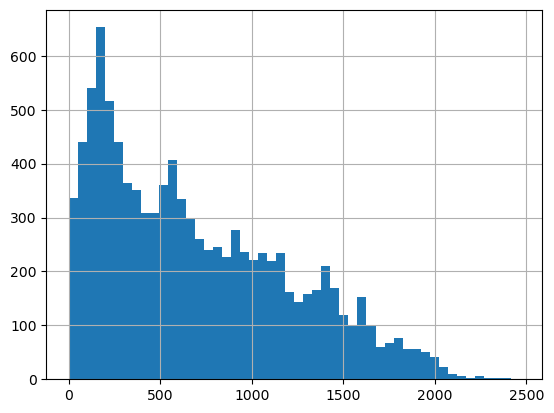

In [16]:
# see distribution of neighbors
print(df_competitors['num_neighbors'].describe())
print(df_competitors['num_neighbors'].le(10).mean())
df_competitors.sample(10_000)['num_neighbors'].hist(bins=50)

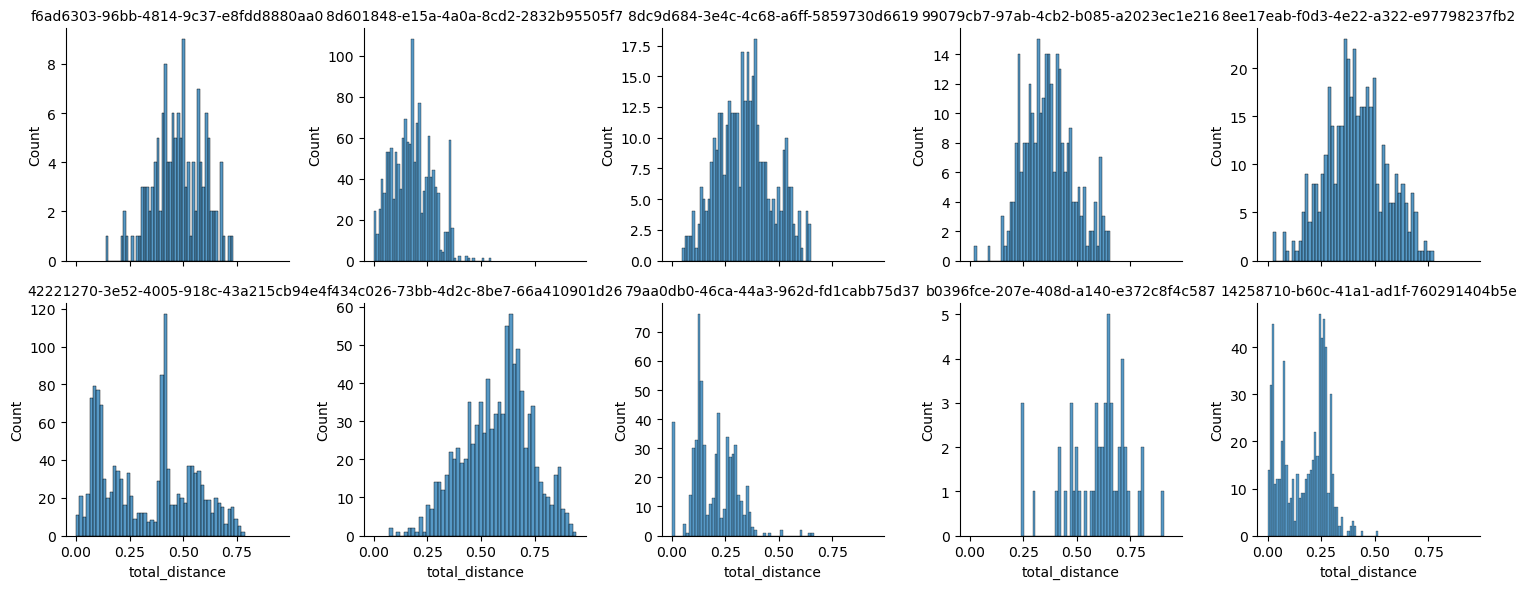

In [17]:
# see 10 distribution of neighbors
df4plot = (
    df_competitors
    .sample(10, random_state=42)
    .explode('neighbors_list')
    .assign(
        observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
        total_distance=lambda x: x['neighbors_list'].str[1],
    )
    .loc[:, ['observation_id_own', 'observation_id_neighbor', 'total_distance']]

)

# plot distribution of neighbors hue by observation_id_own
g = sns.FacetGrid(df4plot, col="observation_id_own", col_wrap=5, height=3, sharey=False)

g.map(sns.histplot, "total_distance", bins=50)

# tight layout
plt.tight_layout()

# format hue titles
g.set_titles("{col_name}")

## S3: Create Sparse Matrix

In [18]:
# # create df that maps observation_id with index
# df_properties_map = (
#     gdf_properties
#     .loc[:, ['observation_id']]
#     .reset_index()
#     .rename(columns={'index': 'property_index'})
# )
# df_properties_map

In [19]:
# # create function to map observation_id to index
# def create_sparse_matrix_in_batches(df, df_indexes, batch_size=1_000):
#     """
#     Convert a large DataFrame with property IDs and neighbor distances into a sparse matrix in batches.

#     Parameters:
#     df (pd.DataFrame): DataFrame with 'observation_id_own' and 'neighbors_list' columns.
#                        'observation_id_own' contains item IDs.
#                        'neighbors_list' contains lists of tuples (neighbor_id, distance).
#     df_indexes (pd.DataFrame): DataFrame with 'observation_id' and 'property_index' columns.
#                                  'observation_id' contains item IDs.
#                                     'property_index' contains item indices.
#     batch_size (int): The number of rows to process in each batch.

#     Returns:
#     scipy.sparse.csr_matrix: The resulting sparse matrix.
#     """
#     # Split DataFrame into approximately equal-sized batches
#     num_batches = df.shape[0] // batch_size
#     chunks = np.array_split(df, num_batches)

#     # Initialize lists
#     # info
#     row_list = []
#     col_list = []
#     data_list = []

#     # garantize the sparse matrix is square
#     max_id = df_indexes['property_index'].max()

#     for chunk in tqdm(chunks, desc="Batches"):
#         # Expand chunk
#         exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

#         # Merge with index map
#         exploded_chunk_ids = (
#             exploded_chunk
#             # property id
#             .merge(df_indexes, left_on='observation_id_own', right_on='observation_id')
#             .loc[:, ['property_index', 'neighbors_list']]
#             # neighbor id
#             .assign(
#                 observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
#                 total_distance=lambda x: x['neighbors_list'].str[1]
#             )
#             .merge(df_indexes, left_on='observation_id_neighbor', right_on='observation_id', suffixes=('_own', '_neighbor'))
#             .loc[:, ['property_index_own', 'property_index_neighbor', 'total_distance']]
#         )

#         # Extract row indices, column indices, and data values
#         rows = exploded_chunk_ids['property_index_own'].values
#         cols = exploded_chunk_ids['property_index_neighbor'].values
#         distances = exploded_chunk_ids['total_distance'].values

#         # Append to lists
#         row_list.append(rows)
#         col_list.append(cols)
#         data_list.append(distances)

#     # Concatenate all chunks
#     rows = np.concatenate(row_list)
#     cols = np.concatenate(col_list)
#     distances = np.concatenate(data_list)

#     # Create the sparse matrix, garanting it is square
#     sparse_matrix = sp.csr_matrix((distances, (rows, cols)), shape=(max_id + 1, max_id + 1))

#     return sparse_matrix

# # Example usage
# sparse_matrix_comps = create_sparse_matrix_in_batches(
#     df=df_competitors,
#     df_indexes=df_properties_map,
#     batch_size=10_000
#     )

# print(sparse_matrix_comps.shape)

In [20]:
# # see shape
# sparse_matrix_comps.shape

In [21]:
# # see how many non-zero elements
# print(f"Non-zero elements: {sparse_matrix_comps.nnz}")
# print(f"Sparsity: {sparse_matrix_comps.nnz / (sparse_matrix_comps.shape[0] * sparse_matrix_comps.shape[1])}")

In [22]:
# # how much memory it uses in MB
# print(f"Memory usage: {sparse_matrix_comps.data.nbytes / 1e+6:.2f} MB")

## S4: Save Sparse Matrix & Raw comps

In [23]:
# # save
# dir_save = "../../data/misc"
# os.makedirs(dir_save, exist_ok=True)

# # save to pickle (in order to save lists, because parquet doesnt support lists)
# df_competitors.to_pickle(f"{dir_save}/df_competitors.pkl")

In [24]:
# # save sparse matrix
# sp.save_npz(f"{dir_save}/sparse_matrix_competitors.npz", sparse_matrix_comps)

---
# Competitors Statistics

## S1: Define statistics

In [25]:
# summary statistics of competitors
def competitors_stats(df, col_to_summarize, xi=0.2):
    # get normalized weights
    n_neighbors = df.shape[0]
    weights_unorm = np.exp(-xi * np.sqrt(n_neighbors) *df['total_distance'])
    weights = weights_unorm / weights_unorm.sum()
    sq_sum_weights = np.sum(weights**2) if n_neighbors > 1 else np.nan

    # get col to summarize
    x_array = df[col_to_summarize].values

    # weighted mean
    w_mean = np.sum(x_array * weights)

    return pd.Series({
        'weighted_mean': w_mean,
        'weighted_std': np.sqrt(
            # unbiased weighted std (theorem)
            (1 / (1 - sq_sum_weights)) * np.sum(weights * (x_array - w_mean)**2)
            ),
        'mean': np.mean(x_array),
        'std': np.std(x_array),
        'num_neighbors': n_neighbors,
    })


def get_info_from_competitors(
    df, df_info, col_to_summarize, xi=0.2, batch_size=2_000
    ):
    # Initialize results list
    all_results = []
    
    # Get unique combinations of city and property type
    partitions = (
        df_info[['city_cluster', 'property_type']]
        .drop_duplicates()
        .values
    )
    
    for city, prop_type in tqdm(partitions, desc="Processing partitions", position=0):
        # Filter relevant data
        df_partition = df[
            (df['city_cluster'] == city) & 
            (df['property_type'] == prop_type)
        ].copy()
        
        df_info_partition = df_info[
            (df_info['city_cluster'] == city) & 
            (df_info['property_type'] == prop_type)
        ].copy()
        
        if df_partition.empty or df_info_partition.empty:
            print(f"No data for city {city} and property type {prop_type}")
            continue
            
        # Process partition in batches
        chunks = np.array_split(df_partition, max(1, df_partition.shape[0] // batch_size))
        merge_cols = ['observation_id', col_to_summarize]
        
        for chunk in tqdm(chunks, desc="Processing chunks", position=1):
            # Expand chunk
            exploded_chunk = (
                chunk
                .explode('neighbors_list')
                .reset_index(drop=True)
                .assign(
                    observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                    total_distance=lambda x: x['neighbors_list'].str[1]
                )
                .merge(
                    df_info_partition[merge_cols],
                    left_on='observation_id_neighbor',
                    right_on='observation_id',
                    suffixes=('_own', '_neighbor')
                )
                .drop(columns=['observation_id', 'neighbors_list'])
            )
            
            # Calculate statistics
            df_competitors_info = (
                exploded_chunk
                .groupby('observation_id_own', as_index=False)
                .apply(
                    competitors_stats,
                    col_to_summarize=col_to_summarize,
                    xi=xi,
                    include_groups=False
                )
            )
            
            all_results.append(df_competitors_info)
    
    # Combine all results
    if not all_results:
        print("No data to process")
        return pd.DataFrame()
        
    return pd.concat(all_results, ignore_index=True)

In [26]:
# add city and property type for each observation_id
df_competitors = (
    df_competitors
    .merge(
        gdf_properties[['observation_id', 'city_cluster', 'property_type']],
        left_on='observation_id_own',
        right_on='observation_id',
    )
    .drop(columns='observation_id')
)

In [27]:
# get info from competitors
df_competitors_info = get_info_from_competitors(
    df=df_competitors,
    df_info=gdf_properties,
    col_to_summarize='log_price_per_sqm',
    xi=2,
    batch_size=200
    )
df_competitors_info

Processing partitions:   0%|          | 0/4 [00:00<?, ?it/s]/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing partitions:  25%|██▌       | 1/4 [00:53<02:39, 53.27s/it]/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing partitions:  50%|█████     | 2/4 [01:04<00:56, 28.33s/it]/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args,

,observation_id_own,weighted_mean,weighted_std,mean,std,num_neighbors
0,002c4791-0bbd-4a23-a656-95131d8ec34a,9.405793,0.104163,9.347847,0.130313,246.0
1,046450e2-b6a1-485c-8c8c-061758a0f6b0,9.839366,0.044131,9.723758,0.241157,1318.0
2,08ed1fc7-91cb-4b76-b064-8c8ec4f67c5e,9.673606,0.216908,9.634056,0.234846,319.0
3,0bf82dad-de22-494b-ba02-8eb45ded4227,9.885798,0.043676,9.777264,0.215586,1101.0
4,0ff4e7db-f225-43be-91b7-f1c1fac999b1,9.679942,0.180876,9.635779,0.143638,130.0
...,...,...,...,...,...,...
42892,f74b6924-695a-4d01-99ee-c2468f851e03,9.569825,0.038462,9.502024,0.155202,821.0
42893,fc8c9d94-980e-4fdb-a3f5-b2b673ee4564,9.584329,0.049521,9.532940,0.174230,902.0
42894,fd108e92-1729-4e1f-bf02-9008bc4dd2b0,9.143390,0.087550,9.169053,0.104347,56.0
42895,fdb35f46-e69e-4652-8d5f-c31f81058db3,9.433807,0.040483,9.421981,0.126260,645.0


In [28]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'weighted_mean': 'competitors_weighted_log_mean_price_per_sqm',
    'weighted_std': 'competitors_weighted_log_std_price_per_sqm',
    'mean': 'competitors_mean_log_price_per_sqm',
    'std': 'competitors_std_log_price_per_sqm',
    'num_neighbors': 'num_competitors',
})
df_competitors_info.head()

,observation_id_own,competitors_weighted_log_mean_price_per_sqm,competitors_weighted_log_std_price_per_sqm,competitors_mean_log_price_per_sqm,competitors_std_log_price_per_sqm,num_competitors
0,002c4791-0bbd-4a23-a656-95131d8ec34a,9.405793,0.104163,9.347847,0.130313,246.0
1,046450e2-b6a1-485c-8c8c-061758a0f6b0,9.839366,0.044131,9.723758,0.241157,1318.0
2,08ed1fc7-91cb-4b76-b064-8c8ec4f67c5e,9.673606,0.216908,9.634056,0.234846,319.0
3,0bf82dad-de22-494b-ba02-8eb45ded4227,9.885798,0.043676,9.777264,0.215586,1101.0
4,0ff4e7db-f225-43be-91b7-f1c1fac999b1,9.679942,0.180876,9.635779,0.143638,130.0


In [29]:
# exp
df_competitors_info['competitors_weighted_mean_price_per_sqm'] = np.exp(df_competitors_info['competitors_weighted_log_mean_price_per_sqm'])
df_competitors_info['competitors_weighted_std_price_per_sqm'] = np.exp(df_competitors_info['competitors_weighted_log_std_price_per_sqm'])
df_competitors_info['competitors_mean_price_per_sqm'] = np.exp(df_competitors_info['competitors_mean_log_price_per_sqm'])
df_competitors_info['competitors_std_price_per_sqm'] = np.exp(df_competitors_info['competitors_std_log_price_per_sqm'])

## S2: EDA

### Correlations

In [30]:
# merge with original data
gdf_properties = (
    gdf_properties
    .merge(
        df_competitors_info,
        how='left',
        left_on='observation_id',
        right_on='observation_id_own',
    )
    .drop(columns=['observation_id_own'])
)

# shape
gdf_properties.shape

(42928, 28)

In [31]:
# see how many properties have competitors
gdf_properties['num_competitors'].describe()

count    42897.000000
mean       688.074318
std        512.421588
min          1.000000
25%        243.000000
50%        572.000000
75%       1040.000000
max       2464.000000
Name: num_competitors, dtype: float64

<Axes: xlabel='price_per_sqm', ylabel='competitors_weighted_mean_price_per_sqm'>

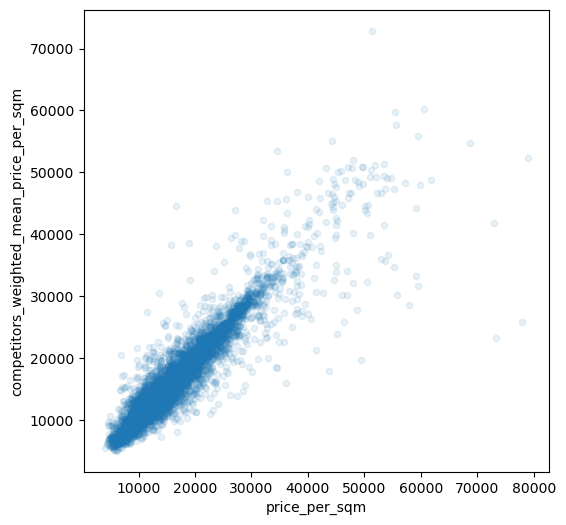

In [32]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .sample(10_000, random_state=42)
    .plot(
        x='price_per_sqm',
        y='competitors_weighted_mean_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

<Axes: xlabel='price_per_sqm', ylabel='competitors_mean_price_per_sqm'>

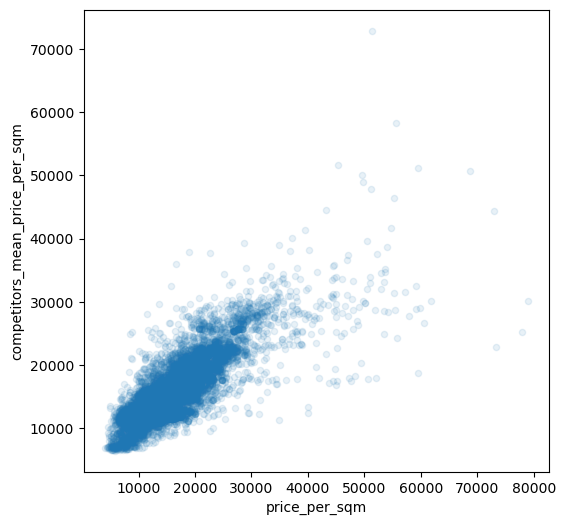

In [33]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .sample(10_000, random_state=42)
    .plot(
        x='price_per_sqm',
        y='competitors_mean_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [34]:
# see corr between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm and competitors_mean_log_price_per_sqm
(
    gdf_properties
    .loc[:, ['price_per_sqm', 'competitors_weighted_mean_price_per_sqm', 'competitors_mean_price_per_sqm']]
    .corr(method='pearson')
)

,price_per_sqm,competitors_weighted_mean_price_per_sqm,competitors_mean_price_per_sqm
price_per_sqm,1.000000,0.941561,0.824794
competitors_weighted_mean_price_per_sqm,0.941561,1.000000,0.871240
competitors_mean_price_per_sqm,0.824794,0.871240,1.000000


### Errors

In [35]:
# error using the mean
gdf_properties = (
    gdf_properties
    .assign(
        error_mean=lambda x: 1 - np.exp(x['competitors_mean_log_price_per_sqm'] - x['log_price_per_sqm']),
        error_weighted_mean=lambda x: 1 - np.exp(x['competitors_weighted_log_mean_price_per_sqm'] - x['log_price_per_sqm'])
    )
)

In [36]:
# describe
gdf_properties[['error_mean', 'error_weighted_mean']].describe()

,error_mean,error_weighted_mean
count,42897.000000,42897.000000
mean,-0.024378,-0.014315
std,0.232910,0.137546
min,-3.073479,-2.048633
25%,-0.119003,-0.045277
50%,0.005793,-0.001501
75%,0.112529,0.039542
max,0.776023,0.729355


In [37]:
# describe abs
gdf_properties[['error_mean', 'error_weighted_mean']].abs().describe()

,error_mean,error_weighted_mean
count,42897.000000,42897.000000
mean,0.162847,0.080880
std,0.168291,0.112169
min,0.000000,0.000000
25%,0.053758,0.014883
50%,0.115541,0.042087
75%,0.215127,0.102735
max,3.073479,2.048633


<Axes: >

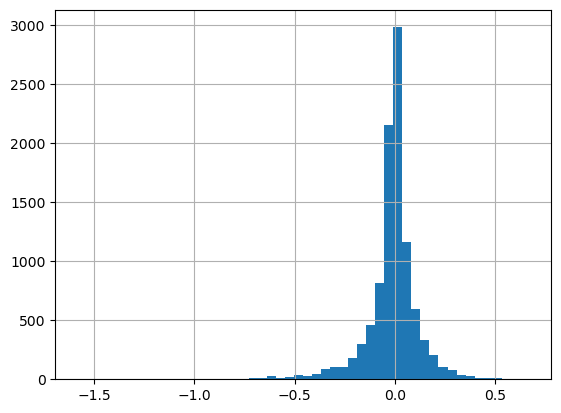

In [38]:
# plot error weighted
(
    gdf_properties
    .query("error_weighted_mean.abs().le(3)", engine='python')
    .sample(10_000, random_state=42)
    ["error_weighted_mean"]
    .hist(bins=50)
)


<Axes: >

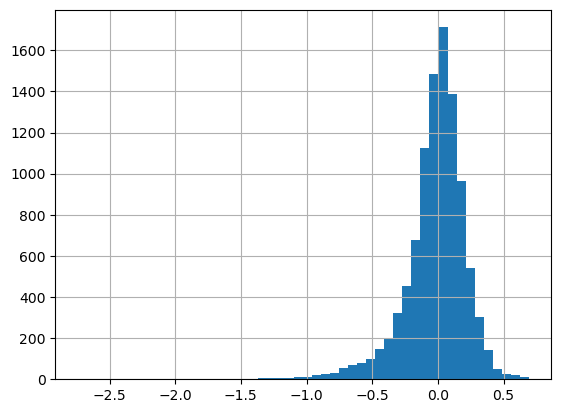

In [39]:
# plot error non-weighted
(
    gdf_properties
    .query("error_mean.abs().le(3)", engine='python')
    .sample(10_000, random_state=42)
    ["error_mean"]
    .hist(bins=50)
)


<Axes: xlabel='num_competitors', ylabel='abs_error_weighted_mean'>

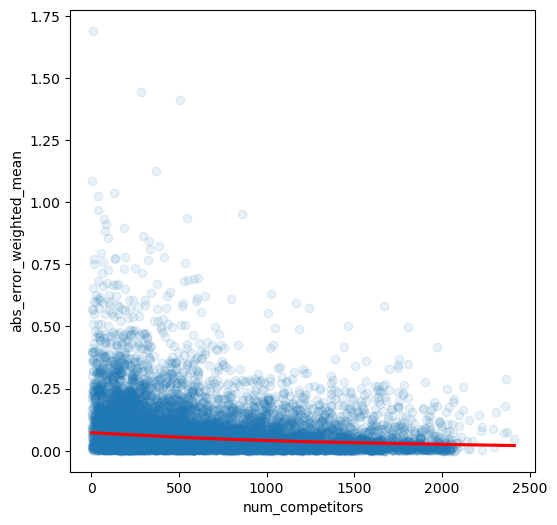

In [40]:
# scatter plot with lowess smoothing of weighted abs error vs num_competitors
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(
    x='num_competitors',
    y='abs_error_weighted_mean',
    data=gdf_properties.assign(abs_error_weighted_mean=lambda x: x['error_weighted_mean'].abs()).sample(10_000),
    lowess=True,
    ax=ax,
    scatter_kws={'alpha': 0.1},
    line_kws={'color': 'red'},
)

In [41]:
# MAPE by cluster
(
    gdf_properties
    .assign(abs_error_weighted_mean=lambda x: x['error_weighted_mean'].abs())
    .groupby('city_cluster')
    .agg(
        mape=('abs_error_weighted_mean', lambda x: x.abs().mean()),
    )
    .sort_values('mape')
    # format
    .style.format("{:.2%}")
)

,mape
city_cluster,
13,6.96%
14,10.39%


---
# Save

In [42]:
# subset gdf_properties to only keep the columns we want
cols2stay = [
    'observation_id', 'competitors_weighted_mean_price_per_sqm',
    'competitors_weighted_std_price_per_sqm',
    'num_competitors'
]
gdf_comps = gdf_properties[cols2stay].copy()

# look
gdf_comps.head()

,observation_id,competitors_weighted_mean_price_per_sqm,competitors_weighted_std_price_per_sqm,num_competitors
0,392740ed-74bc-40e8-9b67-ddfefa28f2aa,17945.381688,1.263231,909.0
1,8c86de18-c3d9-4fe6-88d8-78c050469e3c,16199.186347,1.095234,373.0
2,314f6e31-62a8-4a1c-b7d8-60886bb359e2,22031.899247,1.028413,1723.0
3,7ade3940-905e-4b44-832e-fae353801287,15520.614727,1.154317,1196.0
4,36328900-5739-4b56-a4b0-24095d0e1ab6,25111.790414,1.121747,159.0


In [43]:
# delete gdf_properties
del gdf_properties

In [44]:
# read properties
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# merge
gdf_properties = gdf_properties2.merge(
    gdf_comps,
    how='left',
    on='observation_id'
)

# look
gdf_properties.sort_values('num_competitors', ascending=False).head()

NameError: name 'gdf_properties2' is not defined

In [ ]:
# save to parquet
gdf_properties.to_parquet("../../data/interim/cleaned_data_s5.parquet")

---
# Sandbox